# CDIPS lightcurves

Access the [CDIPS](https://archive.stsci.edu/hlsp/cdips#section-65c131d0-9994-46e6-a370-af9f2e3669cc) project. The article presenting it is [here](https://iopscience-iop-org.libproxy.mit.edu/article/10.3847/1538-4365/ab4a7e)

In [1]:
from astroquery.mast import Observations
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.table import Table

CLUSTER = "NGC 6231"

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

One possible way to access the CDIPS lightcurves is to search within a certain radius of an object.

In [3]:
# Search for CDIPS light curves within 0.001 degrees of V684 Mon.
obs_table = Observations.query_criteria(objectname=CLUSTER, radius="0.5 deg", provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
if(len(obs_table) > 0):
    # Get list of available products for this Observation.
    cdips_products = Observations.get_product_list(obs_table)
    # Download the products for this Observation.
    manifest = Observations.download_products(cdips_products)

Found 1112 CDIPS light curves.
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005964991112015672320-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005964991112015672320-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005964993487144737792-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005964993487144737792-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005964994960322643200-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005964994960322643200-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005964996201564077440-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005964996201564077440-0012-cam1-ccd2_tess_v01_llc.fits with expect

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965003004792325120-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965003004792325120-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965003863786139776-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965003863786139776-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965004237439256960-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965004237439256960-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965004306158915584-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965004306158915584-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965013140915253888-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965013140915253888-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965013170971462656-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965013170971462656-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965013175274990336-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965013175274990336-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005965013205331206144-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005965013205331206144-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966446556172477440-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966446556172477440-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966446663559247232-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966446663559247232-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966446732278743808-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966446732278743808-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966447763070877440-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966447763070877440-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966455562731703296-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966455562731703296-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966455768890135808-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966455768890135808-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966455837609622912-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966455837609622912-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966455867661640448-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966455867661640448-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966459990832818176-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966459990832818176-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966460098217228672-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966460098217228672-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966460132576967552-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966460132576967552-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966460196991284608-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966460196991284608-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966483291041933056-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966483291041933056-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966483394121143808-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966483394121143808-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966483424174422016-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966483424174422016-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966483497200363520-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966483497200363520-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966486005461492608-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966486005461492608-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966486035514696832-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966486035514696832-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966486104234158080-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966486104234158080-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966486241673133312-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966486241673133312-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966499470169708288-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966499470169708288-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966499474479986304-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966499474479986304-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966499538889196544-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966499538889196544-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966499577559203968-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966499577559203968-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966505483123572352-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966505483123572352-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966505517483703296-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966505517483703296-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966505521793974656-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966505521793974656-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966505556153714432-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966505556153714432-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966507549018566400-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966507549018566400-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966507583378319616-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966507583378319616-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966507613427779840-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966507613427779840-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966507617724602880-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966507617724602880-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966511496080784000-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966511496080784000-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966511603467834112-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966511603467834112-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966511667879483776-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966511667879483776-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966511672174259968-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966511672174259968-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966512806058765312-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966512806058765312-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966512840418508800-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966512840418508800-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966512840418512000-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966512840418512000-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966512840418513920-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966512840418513920-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966519879858934528-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966519879858934528-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966520090323396224-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966520090323396224-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966520189096581120-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966520189096581120-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966520223456321152-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966520223456321152-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966521700925001088-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966521700925001088-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966521700925001472-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966521700925001472-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966521705231175040-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966521705231175040-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966521804004301952-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966521804004301952-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966523869894621568-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966523869894621568-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966524037385313024-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966524037385313024-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966524076053210880-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966524076053210880-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966524110412700544-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966524110412700544-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966525416082849024-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966525416082849024-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966525416082850304-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966525416082850304-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966525446134140416-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966525446134140416-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966525484802340480-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966525484802340480-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966526408204715392-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966526408204715392-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966526511288452992-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966526511288452992-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966526515594503040-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966526515594503040-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966526545648192768-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966526545648192768-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966528057473496704-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966528057473496704-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966528233581493120-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966528233581493120-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966528366714338944-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966528366714338944-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966528439739849984-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966528439739849984-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966529500582505728-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966529500582505728-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966529504891804544-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966529504891804544-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966529504891891712-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966529504891891712-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966529642330758656-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966529642330758656-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966531252930343808-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966531252930343808-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966531360319189248-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966531360319189248-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966531360319325184-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966531360319325184-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966531738276324096-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966531738276324096-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966533353184169472-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966533353184169472-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966533387543894016-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966533387543894016-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966533421903630720-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966533421903630720-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966533456263372160-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966533456263372160-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966536033228980352-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966536033228980352-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966536033243655040-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966536033243655040-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966536132013285376-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966536132013285376-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966536170682607616-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966536170682607616-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966537510712545280-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966537510712545280-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966537545072281856-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966537545072281856-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966537579431887872-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966537579431887872-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966537609482137600-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966537609482137600-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966540255182012416-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966540255182012416-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966540358261249024-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966540358261249024-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966540843607154688-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966540843607154688-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966540873657314304-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966540873657314304-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966549227383220224-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966549227383220224-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966549364822175872-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966549364822175872-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966549433541657728-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966549433541657728-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966549497951641216-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966549497951641216-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966551254608100224-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966551254608100224-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966551323327426560-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966551323327426560-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966551529485854720-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966551529485854720-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966551598205339648-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966551598205339648-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966553724198086656-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966553724198086656-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966553762868723712-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966553762868723712-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966553762868724608-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966553762868724608-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005966553797228465152-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005966553797228465152-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005968024355360305920-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005968024355360305920-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005968024531490761088-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005968024531490761088-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005968025596642687104-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005968025596642687104-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969522238123592832-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969522238123592832-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969524295383107968-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969524295383107968-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969524368427398272-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969524368427398272-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969524437146893952-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969524437146893952-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969524604620722944-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969524604620722944-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969527563883288064-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969527563883288064-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969527765716643072-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969527765716643072-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969527937515385856-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969527937515385856-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969528006234866432-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969528006234866432-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969530789371892224-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969530789371892224-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969530828058221952-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969530828058221952-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969530995532048512-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969530995532048512-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969530995532735232-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969530995532735232-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969532924002324480-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969532924002324480-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969532988390648960-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969532988390648960-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969532992721790720-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969532992721790720-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969533130160758784-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969533130160758784-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969535565375583232-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969535565375583232-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969535707141385216-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969535707141385216-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969535771533986816-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969535771533986816-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005969535913264717824-0012-cam1-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005969535913264717824-0012-cam1-ccd2_tess_v01_llc.fits with expected size 273600. [astroquery.que

Counting all the stars:


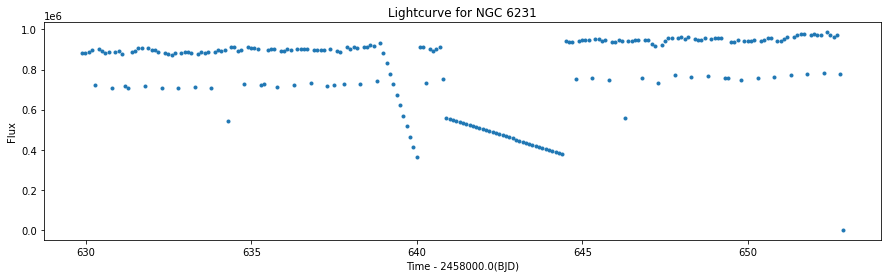

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4))

# Get the time range
NUM_MANIFESTS = 10000
hdu = fits.open(manifest[0][0])
minTime = min(hdu[1].data['TMID_BJD'])
maxTime = max(hdu[1].data['TMID_BJD'])

for i in range(min(len(manifest), NUM_MANIFESTS)):
    try:
        hdu = fits.open(manifest[i][0])
        minTime = max(min(hdu[1].data['TMID_BJD']), minTime)
        maxTime = min(max(hdu[1].data['TMID_BJD']), maxTime)
    except:
        pass
    
if len(manifest) < NUM_MANIFESTS:
    print("Counting all the stars:")
else:
    print("Counting {0} / {1} stars:").format(NUM_MANIFESTS, len(manifest))

BIN_WIDTH = 0.1

# Set up the bins
times = []
counter = minTime
timeOrigin = (minTime // 1000) * 1000
while counter < maxTime:
    times.append(counter - timeOrigin)
    counter+= BIN_WIDTH
times.append(maxTime - timeOrigin)

fluxes = [0] * len(times)

# Add all the light curves
for i in range(min(len(manifest), NUM_MANIFESTS)):
    try:
        personalFluxes = [0] * len(times)
        lastLastTimeIndex = -1
        lastTimeIndex = -1
        literalLastTimeIndex = -1
        for j in range(len(hdu[1].data['TMID_BJD'])):
            timeIndex = int((hdu[1].data['TMID_BJD'][j] - minTime) / BIN_WIDTH)
            fluxes[timeIndex] += hdu[1].data['IFL1'][j]
            personalFluxes[timeIndex] += hdu[1].data['IFL1'][j]
            
            if(literalLastTimeIndex >= 0 and literalLastTimeIndex != timeIndex):
                # We have moved on to the next bin
                if lastLastTimeIndex >= 0 and lastTimeIndex >= 0 and lastTimeIndex > lastLastTimeIndex + 1:
                    for k in range(lastLastTimeIndex+1, lastTimeIndex):
                        progress = (k - (lastLastTimeIndex)) / (lastTimeIndex - (lastLastTimeIndex))
                        fluxes[k] += personalFluxes[lastLastTimeIndex] + \
                            (personalFluxes[lastTimeIndex] - personalFluxes[lastLastTimeIndex]) * progress
            
                lastLastTimeIndex = lastTimeIndex
                lastTimeIndex = literalLastTimeIndex
                
            literalLastTimeIndex = timeIndex
            
        if lastLastTimeIndex >= 0 and lastTimeIndex >= 0 and lastTimeIndex > lastLastTimeIndex + 1:
            for k in range(lastLastTimeIndex+1, lastTimeIndex):
                progress = (k - (lastLastTimeIndex)) / (lastTimeIndex - (lastLastTimeIndex))
                fluxes[k] += personalFluxes[lastLastTimeIndex] + \
                    (personalFluxes[lastTimeIndex] - personalFluxes[lastLastTimeIndex]) * progress
    except:
        print("Died", i)

ax.scatter(times, fluxes, marker='.')
ax.set_xlabel('Time - ' + str(timeOrigin) + '(BJD)');
ax.set_ylabel('Flux');
ax.set_title("Lightcurve for {0}".format(CLUSTER));

## Search directly for stars.

Another way is to name an object directly. Choose either this method or the above.

In [59]:
# Search for CDIPS light curves directly based on TIC ID.
ticid = '220314428'
obs_table = Observations.query_criteria(target_name=ticid, provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
if(len(obs_table) > 0):
    # Get list of available products for this Observation.
    cdips_products = Observations.get_product_list(obs_table)
    # Download the products for this Observation.
    manifest = Observations.download_products(cdips_products)

Found 1 CDIPS light curves.
INFO: Found cached file ./mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0003326715714242517248-0006-cam1-ccd3_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0003326715714242517248-0006-cam1-ccd3_tess_v01_llc.fits with expected size 305280. [astroquery.query]


Finally, we can draw the downloaded lightcurves.

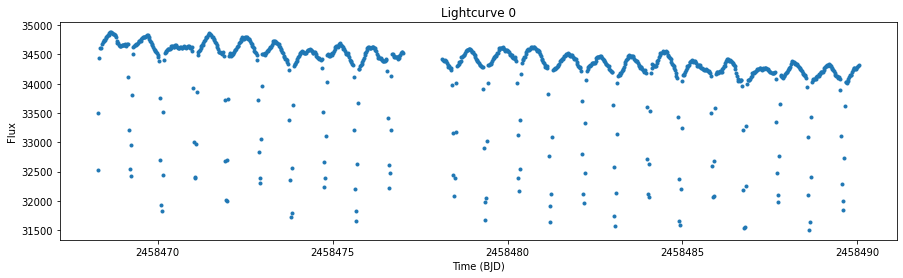

In [62]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4))

#-- Open the spectrum and plot
for i in range(len(manifest)):
    hdu = fits.open(manifest[i][0])
    #print(hdu[1].columns)
    ax.scatter(hdu[1].data['TMID_BJD'].ravel(), hdu[1].data['IFL1'].ravel(), marker='.')
    ax.ticklabel_format(useOffset=False, style='plain');
    ax.set_xlabel('Time (BJD)');
    ax.set_ylabel('Flux');
    ax.set_title("Lightcurve " + str(i))